In [1]:
import sys
import socket
opt_path = '/Users/ebellord/PycharmProjects/opt_trade'
if  opt_path not in sys.path:
    sys.path.append(opt_path)

if socket.gethostname() == 'edmunds-mbp.lan':
    %config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import pandas_datareader.data as web
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import quandl
import nest_asyncio
from implied_to_realized import SPX5MinuteBars
from option_utilities import USZeroYieldCurve
from matplotlib.ticker import FormatStrFormatter
from spx_data_update import UpdateSP500Data, quandle_api
from option_simulation import OptionSimulation, OptionTrades

nest_asyncio.apply()
bars = SPX5MinuteBars(update_bars=True)

# HAR Volatility forecast
Realized volatility is the summation of high frequency returns:
$$RV_{t}=\sum_{i=1}^M r^{2}_{t,i}$$
Where $M=\frac {1}{\Delta}$ and the $\Delta$ period intraday return is defined by:
$$r_{t,i}=log(P_{t-1+i\Delta}) - log(P_{t-1+(i-1)\Delta})$$
The HAR model (Corsi, 2009) can be defined as:
$$RV_{d,t}=\beta + \beta_{d}RV_{d,t-1}+\beta_{w}RV_{w,t-1}+\beta_{m}RV_{m,t-1}+U_{t}$$
based on a 500 day rolling window.

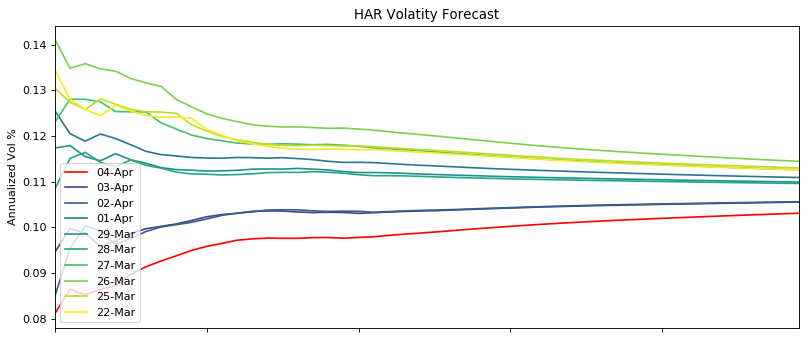

In [2]:
_ = bars.plot_vol_forecast()

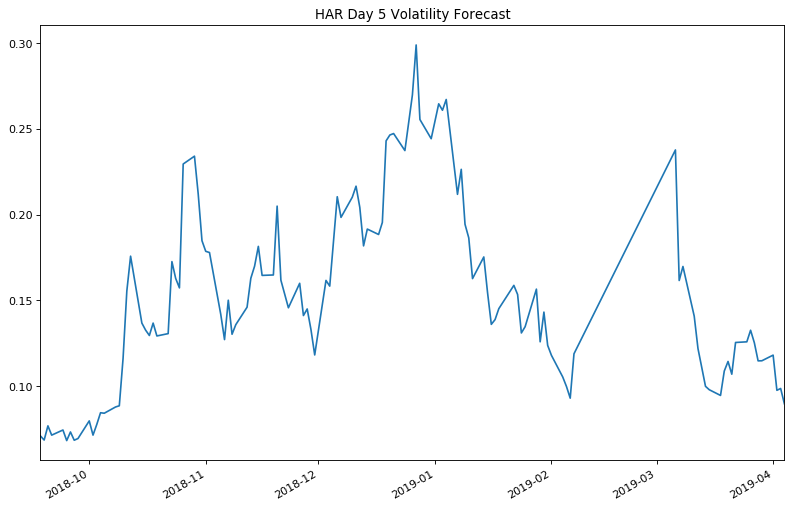

In [3]:
fig, ax = plt.subplots(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')
day_number = 5
bars.har_vol.iloc[day_number, -120:].plot(ax=ax)
_ = ax.set_title('HAR Day {} Volatility Forecast'.format(day_number))

plt.autoscale(enable=True, axis='x', tight=True)


# Volatility risk premium
The volatility risk premium (VRP) is the difference between implied and expected variance. For a collection of articles and summaries of the academic research see https://www.evernote.com/shard/s20/nl/2254793/2774f145-af7d-4e0e-968b-70ac92b9120d/

In [4]:
[sp500, vix] = [web.get_data_yahoo(item, 'JAN-01-90') for item in ['^GSPC', '^VIX']]
vix = vix['Close']
IV = vix**2 / 12
sp5_cls= sp500['Adj Close'].resample('BM', closed='left').ffill().dropna()
quandl.ApiConfig.api_key = quandle_api()
cape = np.log(quandl.get('MULTPL/SHILLER_PE_RATIO_MONTH', collapse='monthly'))
pe = np.log(quandl.get('MULTPL/SP500_PE_RATIO_MONTH', collapse='monthly'))
cape, pe = [item[item.columns[0]] for item in [cape, pe]]
cape, pe = [item.resample('BM', closed='left').ffill() for item in [cape, pe]]
cape = cape.rename('cape')
pe = pe.rename('pe')

In [5]:
zeros = USZeroYieldCurve()
sp5_ret = np.log(sp5_cls / sp5_cls.shift(1))
csh_idx = zeros.cash_index
csh_idx = csh_idx.resample('BM', closed='left').ffill().dropna()
csh_idx = csh_idx.reindex(sp5_cls.index)
csh_idx = csh_idx / csh_idx[0]
sp5_idx = sp5_cls / sp5_cls[0]
excess_ret_idx = sp5_cls / csh_idx
excess_ret_idx= excess_ret_idx /excess_ret_idx[0]
excess_ret = np.log(excess_ret_idx /excess_ret_idx.shift(1))
excess_ret= excess_ret.rename('sp5_excess_ret')

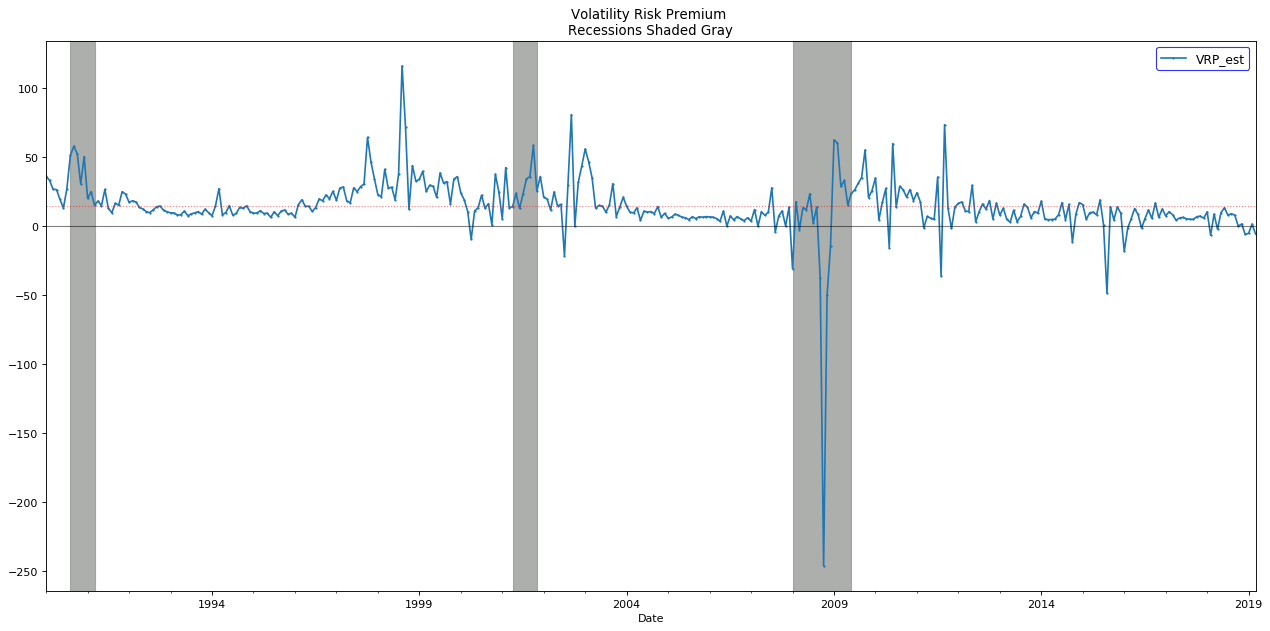

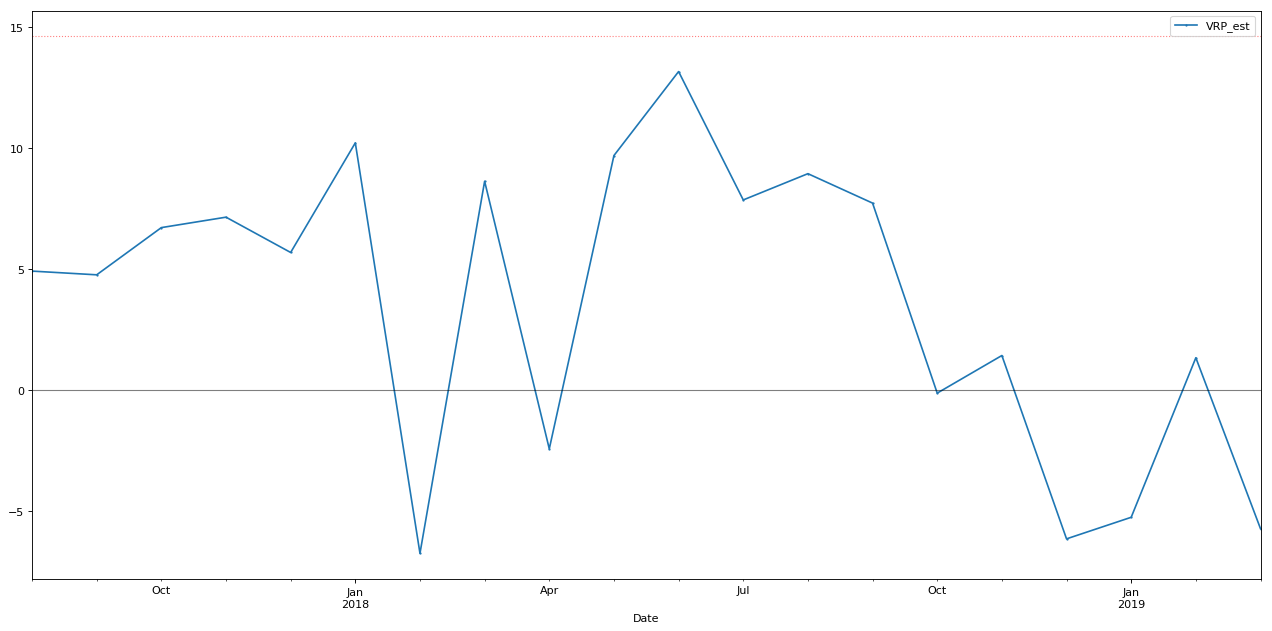

In [6]:
rv = bars.realized_variance * 10000
vrp = bars.vol_risk_premium

rv_estimate = rv.resample('BM', closed='left').ffill().dropna().combine_first(vrp['RV'])
vrp_estimate = IV.resample('BM', closed='left').ffill().dropna() - rv_estimate
vrp_estimate = vrp_estimate.rename('VRP_est')
fig, ax = plt.subplots(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')

ax_1 = vrp_estimate.plot(legend=True, marker='o', ms=1)
recession_dates = web.DataReader(['USREC'], 'fred', vrp_estimate.index[0])
recession_start = recession_dates.index[((recession_dates.USREC != recession_dates.USREC.shift(1)) & 
                                        recession_dates.USREC)]
recession_end = recession_dates.index[((recession_dates.USREC != recession_dates.USREC.shift(-1)) & 
                                        recession_dates.USREC)]

for start, end in zip(recession_start, recession_end):
    ax_1.axvspan(start, end, color=sns.xkcd_rgb['grey'], alpha=0.75)
_ = ax_1.set_title('Volatility Risk Premium' + ' \nRecessions Shaded Gray')
_ = ax_1.axhline(vrp_estimate.mean(), color='r', linestyle=':', linewidth=1, alpha=0.5)
_ = ax_1.axhline(0, color='k', linestyle='-', linewidth=1, alpha=0.5)
_ = ax_1.legend(loc='upper right', fontsize=11, frameon=True).get_frame().set_edgecolor('blue') 
plt.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()
#vrp['VRP'].plot(color='g')
fig, ax = plt.subplots(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
ax_2 = vrp_estimate[-20:].plot(legend=True, marker='o', ms=1, ax=ax)
_ = ax_2.axhline(vrp_estimate.mean(), color='r', linestyle=':', linewidth=1, alpha=0.5)
_ = ax_2.axhline(0, color='k', linestyle='-', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()

In [7]:
regression_data = pd.concat([excess_ret, vrp_estimate.shift(1) / 1000, vrp['VRP'].combine_first(vrp_estimate).shift(1) / 1000, 
                             cape.shift(1) / 1000, pe.shift(1) / 1000], axis=1)
regression_data = regression_data.dropna(axis=0, how='any') 

full_sample = True
vrp_est = True
use_valuation = False
use_cape = False

if vrp_est:
    regression_string = 'sp5_excess_ret ~ VRP_est'
else:
    regression_string = 'sp5_excess_ret ~ VRP'

if use_valuation:    
    if use_cape:
        regression_string = regression_string + ' + cape'
    else:
        regression_string = regression_string + ' + pe'
        
if full_sample:
    results = sm.ols(formula=regression_string, data=regression_data).fit()
else:
    results = sm.ols(formula=regression_string, data=regression_data['1990':'2016']).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp5_excess_ret   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     18.01
Date:                Thu, 04 Apr 2019   Prob (F-statistic):           2.82e-05
Time:                        12:09:26   Log-Likelihood:                 626.07
No. Observations:                 349   AIC:                            -1248.
Df Residuals:                     347   BIC:                            -1240.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0024      0.003     -0.919      0.359      -0.008       0.003
VRP_est        0.4233      0.100      4.244      0.000       0.227       0.619
==============================================================================
Omnibus:                       60.664   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              108.245
Skew:                          -0.976   Prob(JB):                     3.12e-24
Kurtosis:                       4.907   Cond. No.                         46.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""